In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import pandas as pd
import os
import seaborn as sns

In [2]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def load_data(path, dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32) 
    labels = encode_onehot(idx_features_labels[:, -1]) 

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

adj, features, labels, idx_train, idx_val, idx_test=load_data(path="./cora/", dataset="cora")

Loading cora dataset...


In [3]:
print(adj)

tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)


In [4]:
df_features=pd.DataFrame(features.numpy())
df_features

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.058824,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2704,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2705,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2706,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,...,0.052632,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_dir = os.path.expanduser("./cora")

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

In [7]:
node_data.head(20)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
1126012,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
1107140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
1102850,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
31349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1106418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory


In [8]:
df_idx_train=pd.DataFrame(idx_train.numpy())
df_idx_train

,0
0,0
1,1
2,2
3,3
4,4
...,...
135,135
136,136
137,137
138,138


In [9]:
df_idx_val=pd.DataFrame(idx_val.numpy())
df_idx_val

,0
0,200
1,201
2,202
3,203
4,204
...,...
295,495
296,496
297,497
298,498


In [10]:
df_idx_test=pd.DataFrame(idx_test.numpy())
df_idx_test

,0
0,500
1,501
2,502
3,503
4,504
...,...
995,1495
996,1496
997,1497
998,1498


In [11]:
from GCNN import NodeClassificationGCNN

model = NodeClassificationGCNN(features.shape[1], 256, np.max(labels.detach().numpy())+1)

In [12]:
def accuracy(out,label):
    oneHotCodded = out.max(1)[1].type_as(label)
    return oneHotCodded.eq(label).double().sum()/len(label)

In [13]:
import torch.optim as optim
import torch.nn.functional as F

epochs=100
optimizer = optim.Adam(model.parameters(),lr=0.01)
train_losses=[]
val_losses=[]
train_accuracy=[]
val_accuracy=[]
for epoch in range(epochs):
    model.train()
    train_labels=labels[idx_train]
    val_labels=labels[idx_val]
    
    
    optimizer.zero_grad()
    output = model(features, adj)
    train_loss=F.nll_loss(output[idx_train],train_labels)
    train_losses.append(train_loss)
    t_a=accuracy(output[idx_train],train_labels)
    train_accuracy.append(t_a)
    print(f"Training epoch {epoch} ; accuracy: {accuracy(output[idx_train],train_labels)}; loss: {train_loss.item()}")
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    output = model(features, adj)
    val_loss=F.nll_loss(output[idx_val],val_labels)
    val_losses.append(val_loss)
    v_a=accuracy(output[idx_val],val_labels)
    val_accuracy.append(v_a)
    print(f"Validation epoch {epoch} ; accuracy: {accuracy(output[idx_val],val_labels)}; loss: {val_loss.item()}")
    

Training epoch 0 ; accuracy: 0.12857142857142856; loss: 1.9454790353775024
Validation epoch 0 ; accuracy: 0.44666666666666666; loss: 1.8964742422103882
Training epoch 1 ; accuracy: 0.5071428571428571; loss: 1.8837461471557617
Validation epoch 1 ; accuracy: 0.5066666666666667; loss: 1.8363944292068481
Training epoch 2 ; accuracy: 0.6071428571428571; loss: 1.806196928024292
Validation epoch 2 ; accuracy: 0.5633333333333334; loss: 1.7653584480285645
Training epoch 3 ; accuracy: 0.6642857142857143; loss: 1.712522268295288
Validation epoch 3 ; accuracy: 0.6133333333333333; loss: 1.6887750625610352
Training epoch 4 ; accuracy: 0.6928571428571428; loss: 1.6144105195999146
Validation epoch 4 ; accuracy: 0.6433333333333333; loss: 1.6077704429626465
Training epoch 5 ; accuracy: 0.7214285714285714; loss: 1.5084567070007324
Validation epoch 5 ; accuracy: 0.6633333333333333; loss: 1.5247526168823242
Training epoch 6 ; accuracy: 0.7285714285714285; loss: 1.403595209121704
Validation epoch 6 ; accura

/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

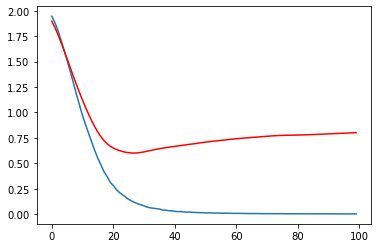

In [14]:
train_losses_float=[float(train_loss.cpu().detach().numpy()) for train_loss in train_losses]
train_loss_indices=[i for i, l in enumerate(train_losses_float)]
plt=sns.lineplot(train_loss_indices,train_losses_float)
val_losses_float=[float(val_loss.cpu().detach().numpy()) for val_loss in val_losses]
val_loss_indices=[i for i, l in enumerate(val_losses_float)]
plt=sns.lineplot(val_loss_indices,val_losses_float,color='r')
plt

In [15]:
t_a = t_a.cpu().detach().numpy()
v_a = v_a.cpu().detach().numpy()

/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kangjunekoo/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

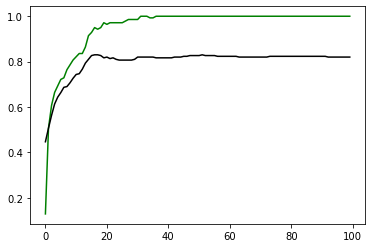

In [16]:
train_accuracy_float=[float(t_a.cpu().detach().numpy()) for t_a in train_accuracy]
t_a_indices=[i for i, l in enumerate(train_accuracy_float)]
plt=sns.lineplot(t_a_indices,train_accuracy_float,color='green')

val_accuracy_float=[float(v_a.cpu().detach().numpy()) for v_a in val_accuracy]
v_a_indices=[i for i, l in enumerate(val_accuracy_float)]
plt=sns.lineplot(v_a_indices,val_accuracy_float,color='black')

plt

In [20]:
test_losses=[]
model.eval()
test_labels=labels[idx_test]
output = model(features, adj)
loss=F.nll_loss(output[idx_test],test_labels)
test_losses.append(loss)
print(f"Test set ; accuracy: {accuracy(output[idx_test],test_labels)}; loss: {loss.item()}")

Test set ; accuracy: 0.669; loss: 0.9876585006713867


torch.Size([2708, 7])


<AxesSubplot:>

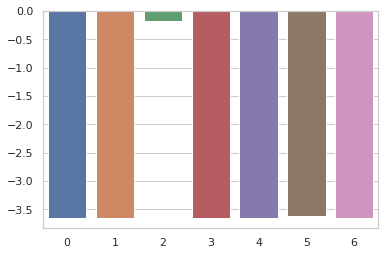

In [21]:
import seaborn as sns
import numpy as np
sample = 500
sns.set_theme(style="whitegrid")
print(model(features, adj).shape)
pred = model(features, adj)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [22]:
output_idx_test=output[idx_test]

In [23]:
df_output_idx_test=pd.DataFrame(output_idx_test.detach().numpy())
df_output_idx_test

,0,1,2,3,4,5,6
0,-3.651942,-3.651942,-0.170443,-3.651942,-3.651942,-3.611710,-3.651942
1,-4.826761,-4.853640,-3.768618,-4.721383,-0.067527,-4.853640,-4.635790
2,-7.502378,-7.502378,-0.020207,-7.502378,-4.087018,-6.900223,-7.502378
3,-5.499911,-5.499911,-5.303761,-5.376230,-0.026949,-5.499911,-5.353931
4,-4.788297,-4.842309,-0.126655,-4.842309,-3.616222,-2.847855,-4.604618
...,...,...,...,...,...,...,...
995,-2.014552,-2.123931,-1.524173,-2.123931,-2.123931,-1.768575,-2.123931
996,-8.949731,-10.944406,-10.944406,-10.944406,-9.862147,-10.944406,-0.000253
997,-5.510885,-6.888665,-5.485894,-6.888665,-6.215913,-6.559607,-0.013734
998,-1.251792,-3.885541,-2.580560,-3.473157,-3.574414,-3.669913,-0.628839


In [24]:
df_test_labels=pd.DataFrame(test_labels.numpy())
print(type(df_test_labels))
df_test_labels.T

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,2,4,2,4,4,4,2,5,5,0,...,4,5,5,4,4,1,6,6,6,4
